In [1]:
%matplotlib inline

Extract segmentation features
=============================

This example shows how to extract segmentation features from the tissue
image.

Features extracted from a nucleus segmentation range from the number of
nuclei per image, over nuclei shapes and sizes, to the intensity of the
input channels within the segmented objects. They are very interpretable
features and provide valuable additional information. Segmentation
features are calculated by using `features = 'segmentation'`, which
calls {func}`squidpy.im.ImageContainer.features_segmentation`.

In addition to `feature_name` and `channels` we can specify the
following `features_kwargs`:

-   `label_layer` - name of label image layer in `img`.
-   `props` - segmentation features that are calculated. See
    [properties]{.title-ref} in `skimage.measure.regionprops_table`.

:::{seealso}
-   {doc}`examples/image/compute_segment_fluo.py` for more
    details on calculating a cell-segmentation.
-   {doc}`examples/image/compute_features.py` for the general
    usage of {func}`squidpy.im.calculate_image_features`.
    
:::


In [3]:
import matplotlib.pyplot as plt

import squidpy as sq

First, let\'s load the fluorescence Visium dataset.


In [4]:
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

Before calculating segmentation features, we need to first calculate a
segmentation using `squidpy.im.segment`.


In [5]:
sq.im.segment(
    img=img,
    layer="image",
    layer_added="segmented_watershed",
    method="watershed",
    channel=0,
)

Now we can calculate segmentation features. Here, we will calculate the
following features:

> -   number of nuclei `label`.
> -   mean area of nuclei `area`.
> -   mean intensity of channels 1 (anti-NEUN) and 2 (anti-GFAP) within
>     nuclei `mean_intensity`.

We use `mask_cicle = True` to ensure that we are only extracting
features from the tissue underneath each Visium spot. For more details
on the image cropping, see
`examples_image_compute_crops.py`.


In [6]:
sq.im.calculate_image_features(
    adata,
    img,
    layer="image",
    features="segmentation",
    key_added="segmentation_features",
    features_kwargs={
        "segmentation": {
            "label_layer": "segmented_watershed",
            "props": ["label", "area", "mean_intensity"],
            "channels": [1, 2],
        }
    },
    mask_circle=True,
)

  0%|          | 0/704 [00:00<?, ?/s]

The result is stored in {attr}`adata.obsm['segmentation_features']`.


In [7]:
adata.obsm["segmentation_features"].head()

segmentation_label  segmentation_area_mean  \
AAACGAGACGGTTGAT-1                  17              174.764706   
AAAGGGATGTAGCAAG-1                  14              100.785714   
AAATGGCATGTCTTGT-1                  16              132.000000   
AAATGGTCAATGTGCC-1                   9              243.000000   
AAATTAACGGGTAGCT-1                   7              229.142857   

                    segmentation_area_std  \
AAACGAGACGGTTGAT-1             291.276810   
AAAGGGATGTAGCAAG-1              80.946348   
AAATGGCATGTCTTGT-1             147.241723   
AAATGGTCAATGTGCC-1             132.341310   
AAATTAACGGGTAGCT-1             203.573383   

                    segmentation_ch-1_mean_intensity_mean  \
AAACGAGACGGTTGAT-1                            5604.069561   
AAAGGGATGTAGCAAG-1                            5034.146353   
AAATGGCATGTCTTGT-1                           11527.768307   
AAATGGTCAATGTGCC-1                            3581.244911   
AAATTAACGGGTAGCT-1                            9038.077440   

                    segmentation_ch-1_mean_intensity_std  \
AAACGAGACGGTTGAT-1                           3100.506862   
AAAGGGATGTAGCAAG-1                           1625.737796   
AAATGGCATGTCTTGT-1                          12227.308457   
AAATGGTCAATGTGCC-1                             46.124320   
AAATTAACGGGTAGCT-1                           8707.493743   

                    segmentation_ch-2_mean_intensity_mean  \
AAACGAGACGGTTGAT-1                            8997.290710   
AAAGGGATGTAGCAAG-1                           10376.489346   
AAATGGCATGTCTTGT-1                            7725.282284   
AAATGGTCAATGTGCC-1                            9664.505991   
AAATTAACGGGTAGCT-1                           10922.808071   

                    segmentation_ch-2_mean_intensity_std  
AAACGAGACGGTTGAT-1                            177.888882  
AAAGGGATGTAGCAAG-1                            564.254124  
AAATGGCATGTCTTGT-1                            947.987907  
AAATGGTCAATGTGCC-1                           1331.259644  
AAATTAACGGGTAGCT-1                           3631.149215

Use `squidpy.pl.extract` to plot the texture features on the tissue
image or have a look at [our interactive visualization
tutorial](../../tutorials/tutorial_napari.ipynb) to learn how to use our
interactive `napari` plugin. Here, we show all calculated segmentation
features.


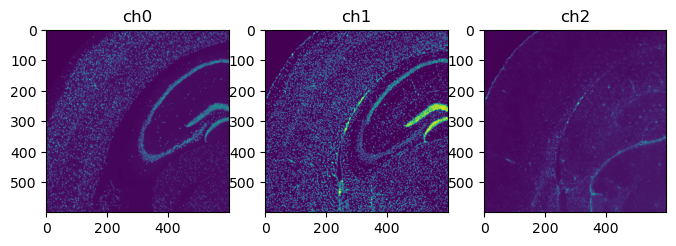

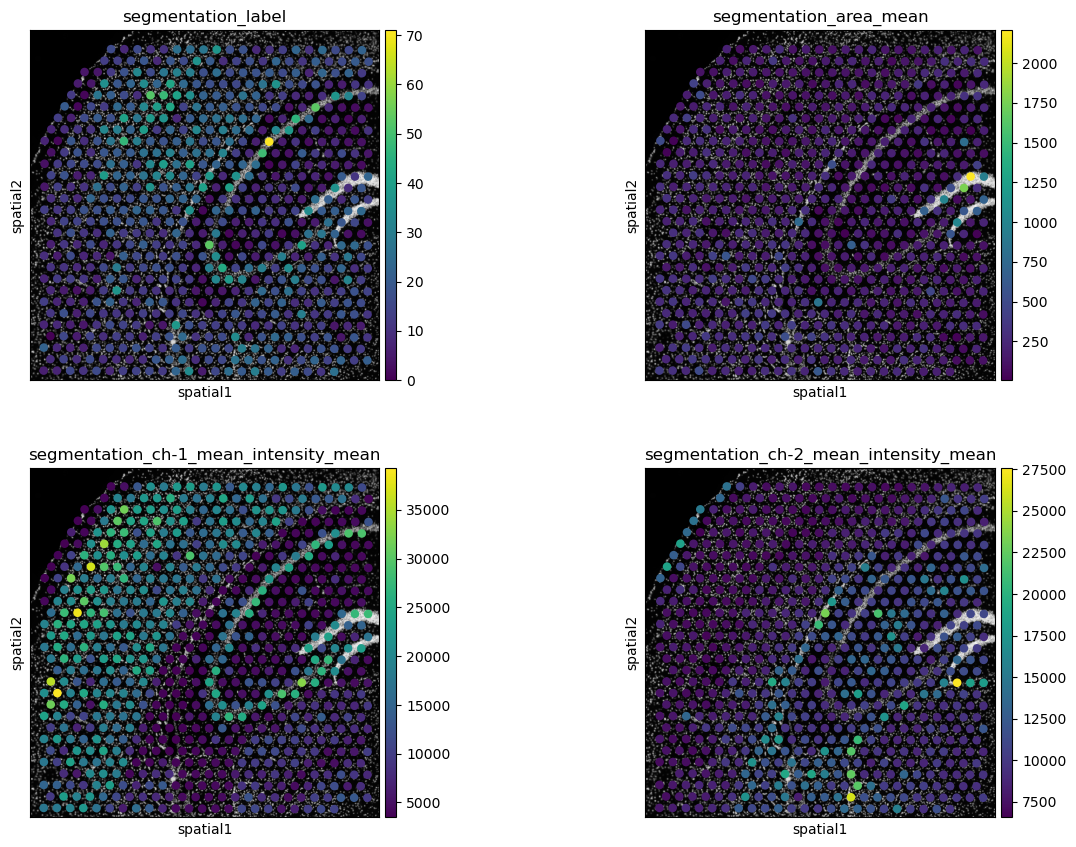

In [8]:
# show all channels (using low-res image contained in adata to save memory)
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
for i, ax in enumerate(axes):
    ax.imshow(
        adata.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["images"][
            "hires"
        ][:, :, i]
    )
    ax.set_title(f"ch{i}")

# plot segmentation features
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "segmentation_features"),
    color=[
        "segmentation_label",
        "segmentation_area_mean",
        "segmentation_ch-1_mean_intensity_mean",
        "segmentation_ch-2_mean_intensity_mean",
    ],
    img_cmap="gray",
    ncols=2,
)

[segmentation\_label]{.title-ref} shows the number of nuclei per spot
and [segmentation\_area\_mean]{.title-ref} the mean are of nuclei per
spot. The remaining two plots show the mean intensity of channels 1 and
2 per spot. As the stains for channels 1 and 2 are specific to Neurons
and Glial cells, respectively, these features show us Neuron and Glial
cell dense areas.
